## Homography
* https://paper.dropbox.com/doc/Homography-WnxRZbNK09By353z7Ddlw

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

## Data

In [2]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
FIGSIZE=(6,6)

## Helpers

In [3]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(img_fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def make_boxes(meta):
    boxes = {}
    for idx,row in meta.iterrows():
        box = json.loads(row.to_json())
        fname = row['filename']
        if fname in boxes:
            boxes[fname].append(box)
        else:
            boxes[fname] = [box]
    return boxes

def threshold(img, color, thresh):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = margin allowed around color
    """
    min_color = np.array([color[0]-thresh, color[1]-thresh, color[2]-thresh])
    max_color = np.array([color[0]+thresh, color[1]+thresh, color[2]+thresh])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

## Erosion / Dilation

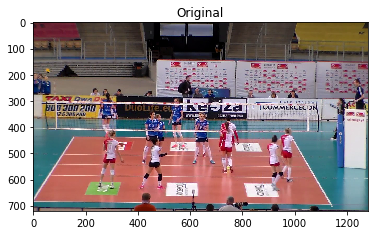

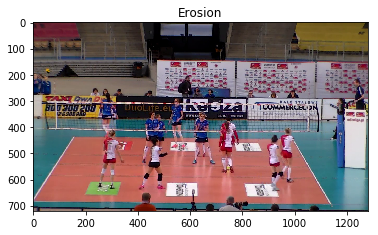

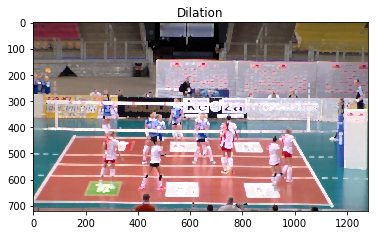

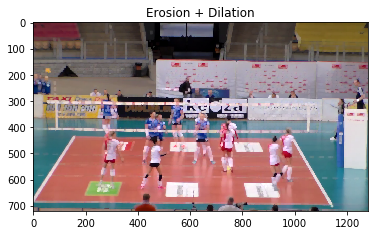

In [4]:
# RGB
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
plot_img(img, title="Original")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
erosion = cv2.erode(img, kernel,iterations = 1)
plot_img(erosion, title="Erosion")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
dilation = cv2.dilate(img, kernel,iterations = 2)
plot_img(dilation, title="Dilation")

img = cv2.dilate(erosion, kernel, iterations = 2)
plot_img(img, title="Erosion + Dilation")

## Edge Detection

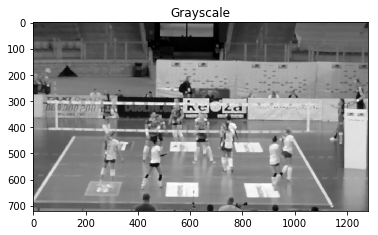

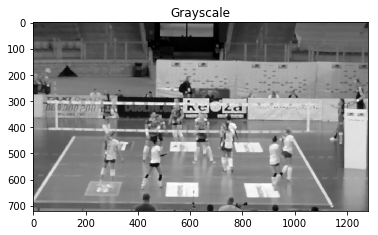

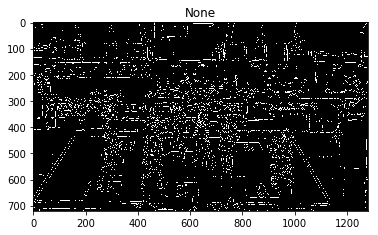

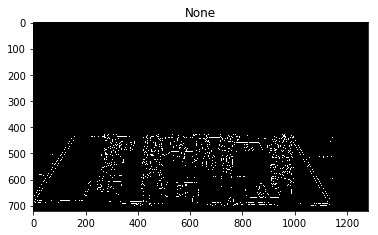

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=3)
plot_img(gray, fs=FIGSIZE, title="Grayscale")
plot_img(gray, title="Grayscale")

# use Canny edge detector to find edges in the image.  The thresholds determine how
# weak or strong an edge will be detected.  These can be tweaked.
lower_threshold = 25
upper_threshold = 25
edges = cv2.Canny(gray, lower_threshold, upper_threshold)
plot_img(edges)

# Mask top of image
edges[:425,:] = 0
edges[700:,:] = 0
edges[:,1150:] = 0
plot_img(edges)

## Hough Transform


* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
* https://docs.opencv.org/3.3.1/d9/db0/tutorial_hough_lines.html
* http://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm
* Polar coords = (rho, theta)
* rho = distance/length of normal
* normal = perpendicular line (along target line) that intersects origin
* theta = angle created by intersection with normal
* Returns lines in parametric (polar coordinates) form (p, theta)
    * p = x cos(theta) + y sin(theta)
    * p = perpendicular distance from origin (0,0) - top left corner
    * theta = angle formed by p and horizontal axis (counter clockwise) (radians)
    * r is measured in pixels and 0 is measured in radians.
![Houghlines](https://docs.opencv.org/3.0-beta/_images/houghlines1.svg)
![hough](http://cdncontribute.geeksforgeeks.org/wp-content/uploads/Hough_transform_diagram.png)

* https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/
* Applications of Hough transform:

    * It is used to isolate features of a particular shape within an image.
    * Tolerant of gaps in feature boundary descriptions and is relatively unaffected by noise.
    * Used extensively in barcode scanning, verification and recognition
* Steps
    * First parameter, Input image should be a binary image, so apply threshold edge detection before finding applying hough transform.
    * Second and third parameters are r and θ(theta) accuracies respectively.
    * Fourth argument is the threshold, which means minimum vote it should get for it to be considered as a line.
    * Remember, number of votes depend upon number of points on the line. So it represents the minimum length of line that should be detected.
   
* ρ = x cos θ + y sin θ

* where:
    * ρ (rho) = distance from origin to the line. [-max_dist to max_dist].
          max_dist is the diagonal length of the image.  
    * θ = angle from origin to the line. [-90° to 90°]

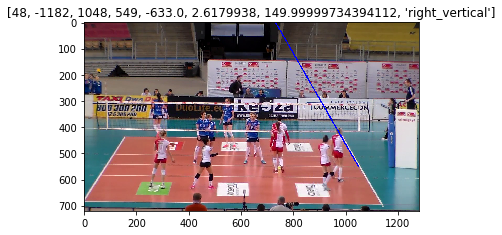

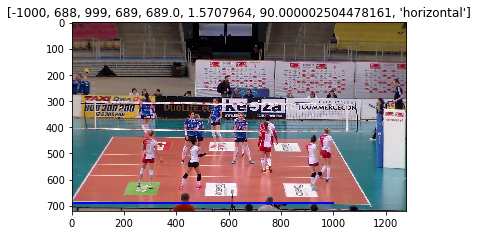

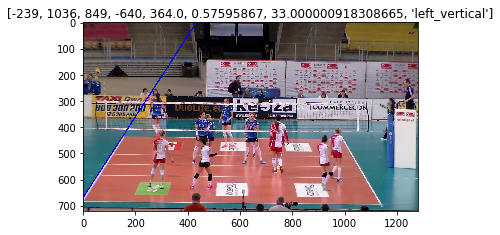

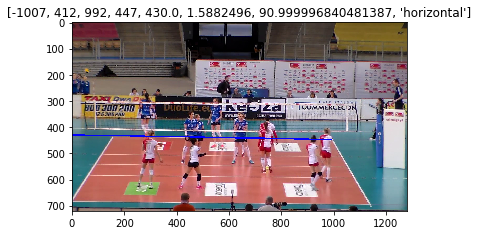

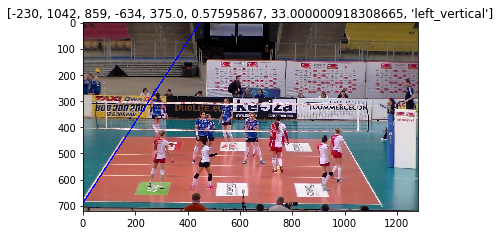

In [6]:
# Higher threshold means a line needs to be stronger to be detected
thresh = 150
lines = cv2.HoughLines(edges, 1, np.pi / 180, thresh)
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)

# convert polor coordinates to x,y pixel coordinates
# origin (0,0) is top left in numpy/cv2
# p = distance from origin (perpendicular to hough line)
# theta = angle in radians formed by perpendicular line
coords = []
plot_count = 0
for line in lines:
    for rho, theta in line:
        degrees = theta * (180/math.pi)
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * -b)
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * -b)
        y2 = int(y0 - 1000 * a)

        if degrees > 145:
            orient = 'right_vertical'
        elif degrees < 45:
            orient = 'left_vertical'
        elif degrees > 85 and degrees < 95:
            orient = 'horizontal'
        else:
            orient = 'other'
            
        coords.append([x1,y1,x2,y2,rho,theta,degrees,orient])

        if plot_count < 5:
            img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
            cv2.line(img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 0, 255), thickness=3)
            plot_img(img, title=coords[-1])
        plot_count += 1

## Cleaning up Hough Lines

* https://campushippo.com/lessons/detect-highway-lane-lines-with-opencv-and-python-21438a3e2
* How to clean up the lines, extend them, and average nearby lines?
* https://stackoverflow.com/questions/44449871/fine-tuning-hough-line-function-parameters-opencv
* Since the lines are mostly vertical and horizontal, you can easily split the lines based on their position. If the two y-coordinates of one line are near each other, then the line is mostly horizontal. If the two x-coordinates are near each other, then the line is mostly vertical. So you can segment your lines into vertical lines and horizontal lines that way.
* https://alyssaq.github.io/2014/understanding-hough-transform/

### Detecting Horizontal / Vertical Lines

In [7]:
"""
r = negative when base of normal is above the top of image (negative y value)
y1,y2 = negative when base of normal is above top of image
theta = between 0 and 90 when the base of the normal is inside the image
theta > 90 when base of normal is outside the imag

Horizontal lines
   * Angles close to 90
   
Vertical lines
    * Angles close to 180/0
    
A volleyball court viewed straight on should have
    * 2 horizontal lines
    * 1 vertical line with angle close to 0
    * 1 vertical line with angle close to 180
    
Taking a look at the image, we can set some sensible defaults

vertical_left = angle < 45 degres
vertical_right = angle > 145 degrees
horizonal lines = angle between 85 and 95
"""

for coord in coords:
    print(coord)
    if coord[-2] > 145:
        print('right vertical')
    elif coord[-2] < 45:
        print('left vertical')
    elif coord[-2] > 85 and coord[-2] < 95:
        print('horizontal')
    else:
        print('other')

[48, -1182, 1048, 549, -633.0, 2.6179938, 149.99999734394112, 'right_vertical']
right vertical
[-1000, 688, 999, 689, 689.0, 1.5707964, 90.000002504478161, 'horizontal']
horizontal
[-239, 1036, 849, -640, 364.0, 0.57595867, 33.000000918308665, 'left_vertical']
left vertical
[-1007, 412, 992, 447, 430.0, 1.5882496, 90.999996840481387, 'horizontal']
horizontal
[-230, 1042, 859, -634, 375.0, 0.57595867, 33.000000918308665, 'left_vertical']
left vertical
[-1011, 666, 987, 701, 684.0, 1.5882496, 90.999996840481387, 'horizontal']
horizontal
[-1011, 660, 988, 695, 678.0, 1.5882496, 90.999996840481387, 'horizontal']
horizontal
[-1000, 696, 999, 697, 697.0, 1.5707964, 90.000002504478161, 'horizontal']
horizontal
[56, -1187, 1056, 544, -643.0, 2.6179938, 149.99999734394112, 'right_vertical']
right vertical
[20, -1179, 1050, 535, -625.0, 2.6005406, 149.00000300793789, 'right_vertical']
right vertical
[-1000, 439, 999, 440, 440.0, 1.5707964, 90.000002504478161, 'horizontal']
horizontal
[-1007, 410

### Extending Hough Lines

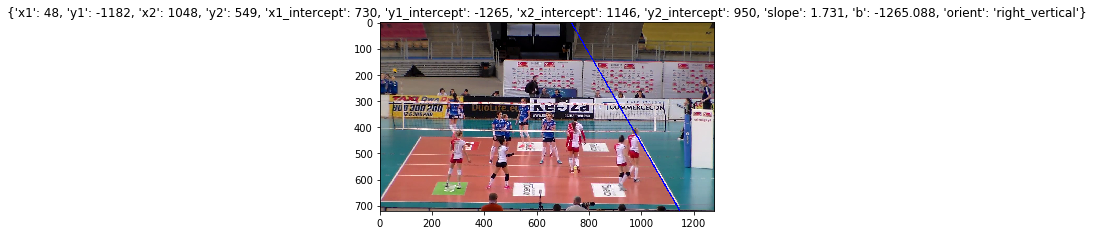

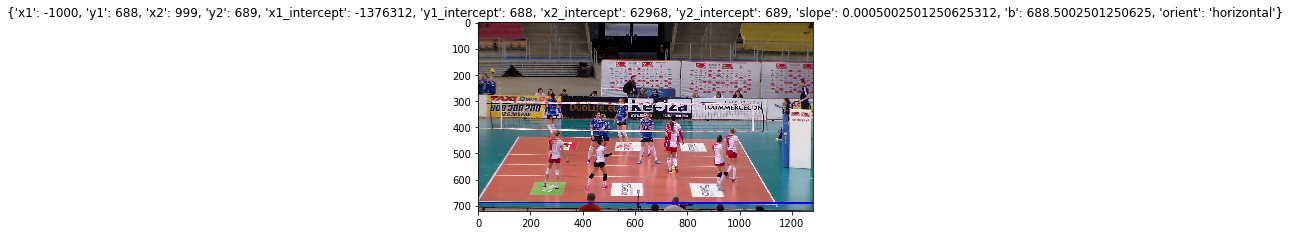

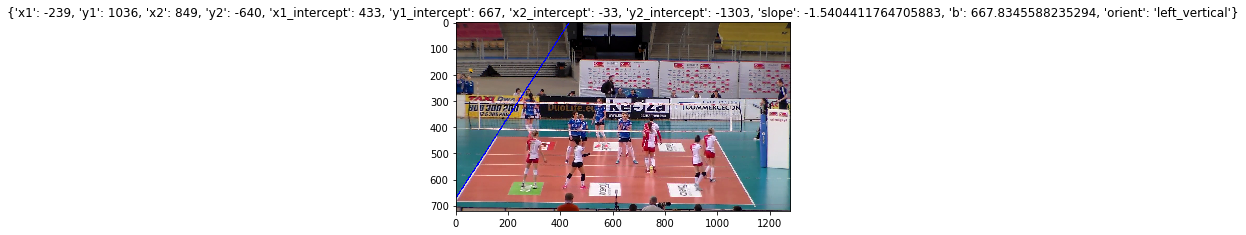

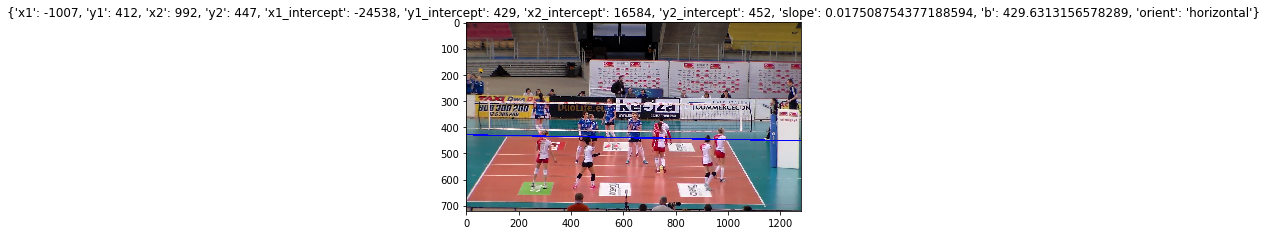

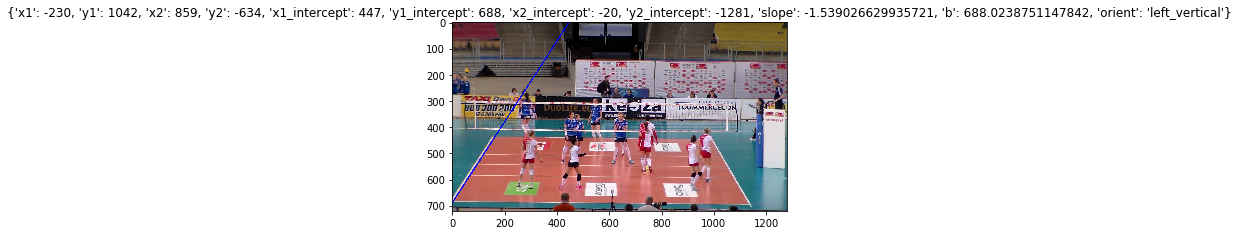

In [8]:
height,width,c = img.shape
new_coords = []
plot_count = 0
for coord in coords:
    x1,y1,x2,y2 = coord[:4]
    slope = (y2-y1) / (x2-x1)
    #y = mx + b
    b = y1 - slope * x1
    # x intercepts
    x1_int = int(-b / slope) # -b/m = 0 = mx + b), x when y == 0
    x2_int = int((height - b) / slope) #x when y == height
    # y intercepts
    y1_int = int(b) #y when x == 0
    y2_int = int(slope * width + b) #y when x == width
    details = {
        'x1':x1,
        'y1':y1,
        'x2':x2,
        'y2':y2,
        'x1_intercept': x1_int,
        'y1_intercept': y1_int,
        'x2_intercept': x2_int,
        'y2_intercept': y2_int,
        'slope': slope,
        'b': b,
        'orient': coord[-1]
    }
    new_coords.append(details)
    if plot_count < 5:
        img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
        if details['orient'] == 'horizontal':
            cv2.line(img, pt1=(0, y1_int), pt2=(width, y2_int), 
                     color=(0, 0, 255), thickness=3)
        else:
            cv2.line(img, pt1=(x1_int, 0), pt2=(x2_int, height), 
                 color=(0, 0, 255), thickness=3)
        plot_img(img, title=details)
    plot_count += 1

## Finding the Intersection of Lines

* Cross Product of two vectors gives the intersection
* Steps:
    * Given two points, find the line
    * Find the slope
    * Find the b intercept
    * Convert to standard form (Ax + By + C = 0)
    * Convert to vector form ([A B C])
    * Compute the cross product
* Cross product
    * https://paper.dropbox.com/doc/Vectors-ehJskFyt7xGIdePpamfhu 
    * https://www.symbolab.com/solver/vector-cross-product-calculator
* https://stackoverflow.com/questions/44449871/fine-tuning-hough-line-function-parameters-opencv

### Intersection w Cross Product

In [9]:
def vector_from_points(x1,y1,x2,y2):
    m = (y2-y1) / (x2-x1)
    b = y1 - (m * x1)
    # Ax + By + C
    #1y - mx - b = 0
    v = np.array([-m, 1, -b])
    return v

def intersection_two_points(A, B):
    Av = vector_from_points(A['x1'], A['y1'], A['x2'], A['y2'])
    Bv = vector_from_points(B['x1'], B['y1'], B['x2'], B['y2'])
    cross = np.cross(Av, Bv)
    cross /= cross[2]
    return int(cross[0]), int(cross[1])

A = {'x1':0, 'y1':4, 'x2':4, 'y2':0}
B = {'x1':0, 'y1':0, 'x2':4, 'y2':4}
intersection_two_points(A, B)

(2, 2)

### Include horizontal and vertical line intersections only

In [10]:
def find_intersecting_points(lines):
    horizontal_lines = [l for l in lines if 'horizontal' in l['orient']]
    vertical_lines = [l for l in lines if 'vertical' in l['orient']]
    intersecting_points = []
    for hl in horizontal_lines:
        hp = {'x1':hl['x1'], 'y1':hl['y1'], 'x2':hl['x2'], 'y2':hl['y2']}
        for vl in vertical_lines:
            vp = {'x1':vl['x1'], 'y1':vl['y1'], 'x2':vl['x2'], 'y2':vl['y2']}
            intersection = intersection_two_points(hp, vp)
            intersecting_points.append(intersection)
    return intersecting_points

In [11]:
intersecting_points = find_intersecting_points(new_coords)
intersecting_points

[(1128, 689),
 (-13, 688),
 (0, 688),
 (1139, 689),
 (1142, 689),
 (989, 446),
 (152, 432),
 (166, 432),
 (1000, 447),
 (997, 447),
 (1137, 703),
 (-10, 683),
 (2, 683),
 (1148, 703),
 (1151, 703),
 (1133, 697),
 (-6, 677),
 (6, 677),
 (1144, 697),
 (1147, 697),
 (1133, 697),
 (-18, 696),
 (-5, 696),
 (1144, 697),
 (1147, 697),
 (985, 439),
 (148, 439),
 (161, 439),
 (995, 439),
 (992, 439),
 (987, 444),
 (154, 430),
 (167, 430),
 (998, 445),
 (995, 445),
 (1130, 691),
 (-2, 671),
 (10, 671),
 (1141, 691),
 (1144, 691),
 (1131, 693),
 (-16, 692),
 (-2, 692),
 (1142, 693),
 (1144, 693)]

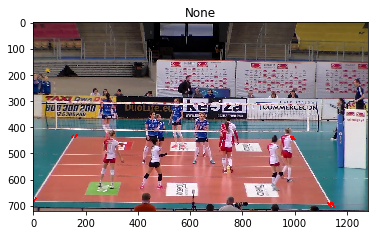

In [12]:
# PLot
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
for point in intersecting_points:
    cv2.circle(img, point, 1, color=(255,0,0), thickness=5)
    
plot_img(img, title=None)

### Cluster points with K-Means

In [13]:
points = np.array(intersecting_points)
print(points.shape)
def cluster_points(points, n_clusters):
    points = np.float32(points)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, _, centers = cv2.kmeans(points, n_clusters, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    return centers.astype(int)
centers = cluster_points(points, 4)

(45, 2)


In [14]:
centers

array([[  -4,  684],
       [1140,  695],
       [ 993,  443],
       [ 158,  433]])

In [15]:
mean_x = centers[:,0].mean()
mean_y = centers[:,1].mean()
print(mean_x, mean_y)
court_pts = {
    'top_left': {'x':0, 'y':0},
    'top_right': {'x':0, 'y':0},
    'bottom_left': {'x':0, 'y':0},
    'bottom_right': {'x':0, 'y':0},
}
for pt in centers:
    x,y = pt
    if x < mean_x and y < mean_y:
        court_pts['top_left']['x'] = x
        court_pts['top_left']['y'] = y
    elif x < mean_x and y > mean_y:
        court_pts['bottom_left']['x'] = x
        court_pts['bottom_left']['y'] = y
    elif x > mean_x and y < mean_y:
        court_pts['top_right']['x'] = x
        court_pts['top_right']['y'] = y
    elif x > mean_x and y > mean_y:
        court_pts['bottom_right']['x'] = x
        court_pts['bottom_right']['y'] = y


571.75 563.75


In [16]:
inner_court_img_corners = np.array([
    [court_pts['top_left']['x'], court_pts['top_left']['y']],
    [court_pts['top_right']['x'], court_pts['top_right']['y']],
    [court_pts['bottom_left']['x'], court_pts['bottom_left']['y']],
    [court_pts['bottom_right']['x'], court_pts['bottom_right']['y']]
])

[158 433]
[993 443]
[ -4 684]
[1140  695]


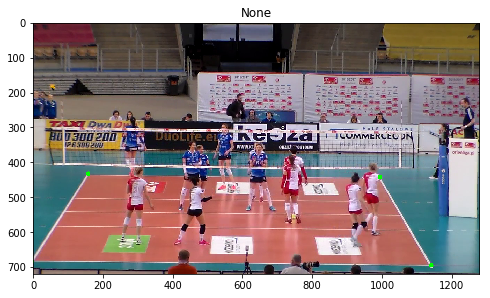

In [17]:
# PLot
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
for c in inner_court_img_corners:
    print(c)
    cv2.circle(img, (c[0],c[1]), 1, color=(0,255,0), thickness=10)
    
plot_img(img, fs=(8,8), title=None)

## Homography (2D)

* https://docs.opencv.org/trunk/d9/dab/tutorial_homography.html
* http://cvgl.stanford.edu/teaching/cs231a_winter1415/prev/projects/basketball.pdf
* http://cgv.cs.nthu.edu.tw/download/file?guid=7afc2f1b-927b-11e5-b494-00113247b9b2
* http://www.cs.ubc.ca/~murphyk/papers/weilwun-pami12.pdf
* http://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf
* https://www.researchgate.net/publication/257627726_Automatic_player_position_detection_in_basketball_games
* https://thesai.org/Downloads/Volume6No6/Paper_19-Application_of_Image_Processing_Techniques.pdf

![Volleyball](http://files.leagueathletics.com/Images/Club/5663/VolleyBallCourtDiagram.jpg)
\![](https://i2.wp.com/technofizi.net/wp-content/uploads/2015/10/volleyball-court-dimensions.png)
![](http://www.courtdimensions.net/_images/vlly-900.png)

## Plot Top Down 2D Map

* Dimensions = 30x60 feet (w,h) - inner court
* Pixel spacing = 10 pixels / foot = (300 x 600 pixel court)
* Center line = 30 feet between top and bottom (30,30) = 300 pixels wide
* Padding = 4 feet = 40 pixels

Img 350 650 Court 300 600
{'top_left': {'x': 50, 'y': 50}, 'top_right': {'x': 300, 'y': 50}, 'bottom_left': {'x': 50, 'y': 600}, 'bottom_right': {'x': 300, 'y': 600}, 'center_left': {'x': 50, 'y': 325}, 'center_right': {'x': 300, 'y': 325}}


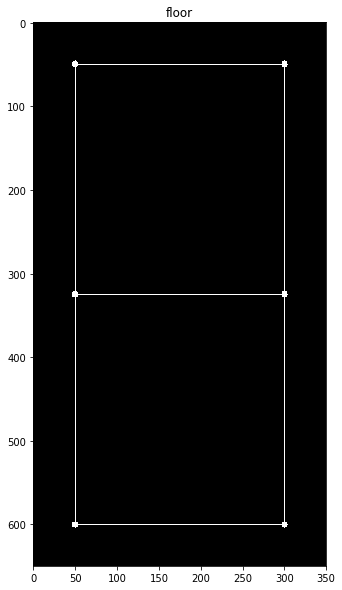

In [18]:
width_ft = 30
height_ft = 60
padding_ft = 5
pixel_per_ft = 10
court_width_px = width_ft * pixel_per_ft
court_height_px = height_ft * pixel_per_ft
padding_px = padding_ft * pixel_per_ft
img_width = court_width_px + padding_px
img_height = court_height_px + padding_px
print("Img", img_width, img_height, "Court", court_width_px, court_height_px)
floor = np.zeros((img_height, img_width))
floor_pts = {
    'top_left': {'x':padding_px, 'y':padding_px},
    'top_right': {'x':img_width - padding_px, 'y':padding_px},
    'bottom_left': {'x':padding_px, 'y':img_height - padding_px},
    'bottom_right': {'x':img_width - padding_px, 'y':img_height - padding_px},
    'center_left': {'x':padding_px, 'y':img_height//2},
    'center_right': {'x':img_width - padding_px, 'y':img_height//2},
}
print(floor_pts)
inner_court_floor_corners = np.array([
    [floor_pts['top_left']['x'], floor_pts['top_left']['y']],
    [floor_pts['top_right']['x'], floor_pts['top_right']['y']],
    [floor_pts['bottom_left']['x'], floor_pts['bottom_left']['y']],
    [floor_pts['bottom_right']['x'], floor_pts['bottom_right']['y']]
])
inner_court_lines = {
    'top': {
        'x1': floor_pts['top_left']['x'],
        'y1': floor_pts['top_left']['y'],
        'x2': floor_pts['top_right']['x'],
        'y2': floor_pts['top_right']['y'],
    },
    'bottom': {
        'x1': floor_pts['bottom_left']['x'],
        'y1': floor_pts['bottom_left']['y'],
        'x2': floor_pts['bottom_right']['x'],
        'y2': floor_pts['bottom_right']['y'],
    },
    'left': {
        'x1': floor_pts['top_left']['x'],
        'y1': floor_pts['top_left']['y'],
        'x2': floor_pts['bottom_left']['x'],
        'y2': floor_pts['bottom_left']['y'],
    },
    'right': {
        'x1': floor_pts['top_right']['x'],
        'y1': floor_pts['top_right']['y'],
        'x2': floor_pts['bottom_right']['x'],
        'y2': floor_pts['bottom_right']['y'],
    },
    'center': {
        'x1': floor_pts['center_left']['x'],
        'y1': floor_pts['center_left']['y'],
        'x2': floor_pts['center_right']['x'],
        'y2': floor_pts['center_right']['y'],
    }
    
}
for point in floor_pts.values():
    pt = point['x'],point['y']
    cv2.circle(floor, pt, 1, color=(255,255,255), thickness=5)
for line in inner_court_lines.values():
    pt1 = (line['x1'],line['y1'])
    pt2 = (line['x2'],line['y2'])
    cv2.line(floor, pt1=pt1, pt2=pt2, 
             color=(255, 255, 255), thickness=1)
plot_img(floor, fs=(10,10), title="floor")

## Homography Matrix

* https://www.slideshare.net/mimimau/introduction-to-homography
* https://www.cs.ubc.ca/grads/resources/thesis/May09/Dubrofsky_Elan.pdf
* https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws11-12/3DCV_WS11-12_lec04.pdf
* http://6.869.csail.mit.edu/fa12/lectures/lecture13ransac/lecture13ransac.pdf
* https://www.researchgate.net/publication/228541275_Combing_Line_and_Point_Correspondences_to_Calculate_Homographies_with_Applications_in_Hockey_Rink_Registration
* np.linalg.lstsqrs
![](https://image.slidesharecdn.com/lecture16-110524023525-phpapp02/95/lecture16-25-728.jpg?cb=1306204617)

In [40]:
print("Image Corners", inner_court_img_corners)
print("Floor Corners", inner_court_floor_corners)

Image Corners [[ 158  433]
 [ 993  443]
 [  -4  684]
 [1140  695]]
Floor Corners [[ 50  50]
 [300  50]
 [ 50 600]
 [300 600]]


In [41]:
# Get A
# A*H = P

A = []
B = []
for img_pt, floor_pt in zip(inner_court_img_corners, inner_court_floor_corners):
    print(img_pt, floor_pt)
    # [x y 1 0 0 0 -x1x -x1y -x1]
    A.append(
        [img_pt[0], img_pt[1], 1, 0, 0, 0, 
         -floor_pt[0]*img_pt[0], -floor_pt[0]*img_pt[1], -floor_pt[0]]
    )
    # [0 0 0 x y 1 -y1x -y1y -y1]
    A.append(
        [0, 0, 0, img_pt[0], img_pt[1], 1, 
         -floor_pt[1]*img_pt[0], -floor_pt[1]*img_pt[1], -floor_pt[1]]
    )
    B.extend([floor_pt[0], floor_pt[1]])
A = np.array(A)
B = np.array(B)
# A = (2n, 9)m B = 2n
print("A:", A.T.shape, "B:", B.shape)
pd.DataFrame(A)

[158 433] [50 50]
[993 443] [300  50]
[ -4 684] [ 50 600]
[1140  695] [300 600]
A: (9, 8) B: (8,)


,0,1,2,3,4,5,6,7,8
0,158,433,1,0,0,0,-7900,-21650,-50
1,0,0,0,158,433,1,-7900,-21650,-50
2,993,443,1,0,0,0,-297900,-132900,-300
3,0,0,0,993,443,1,-49650,-22150,-50
4,-4,684,1,0,0,0,200,-34200,-50
5,0,0,0,-4,684,1,2400,-410400,-600
6,1140,695,1,0,0,0,-342000,-208500,-300
7,0,0,0,1140,695,1,-684000,-417000,-600


## Least Squares

* https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html
* http://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf


In [42]:
# Non-homogenous
# A*H = B
# Lower quality results
# h = inverse(A.T * A) * (A.T b)

In [43]:
[V,W] = np.linalg.eig(np.dot(A.T, A))
m = W[:,-1]
H = np.reshape(m, (3,3))
H_inv = np.linalg.inv(H)

## SVD

* https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html
* https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
* https://github.com/jmlipman/LAID/blob/master/IP/homography.py
* http://laid.delanover.com/homography-estimation-explanation-and-python-implementation/

In [48]:
# U, s, V = np.linalg.svd(A, full_matrices=True)
# U.shape, s.shape, V.shape
[U,S,V] = np.linalg.svd(A)

# singular value of A
# eigen vector to the smallest eigen value of A.T * A
m = V[-1,:]
H = np.reshape(m, (3,3))

# It should be close to zero
print("This value should be close to zero: "+str(np.sum(np.dot(A,m))))

# To map from floor to image
H_inv = np.linalg.inv(H)

This value should be close to zero: 4.43950431972e-14


## Apply Homography

1. P1 = H * P2
2. Divide by W

In [49]:
# Prepare the Image Point
map_points = []
for cpt, fpt in zip(inner_court_img_corners.tolist(), inner_court_floor_corners.tolist()):
    cpt.append(1)
    pt_arr = np.array([cpt]).T

    # Map Image Point to Floor Point
    # P2 = H * P1 (dot product)
    map_pt = H @ pt_arr
    
    # Divide by W
    map_pt /= map_pt[2][0]
    map_pt = map_pt.astype(int)
    map_points.append(map_pt.squeeze().tolist())
    
    # UNDO - Map Floor Point to Image Point
    # Compute inverse (return to image coords)
    inv_pt = H_inv @ map_pt
    inv_pt /= inv_pt[2][0]
    inv_pt = inv_pt.astype(int)
    print("Img:", cpt, "Floor:", fpt, "Map:", map_pt.flatten(), "Inv", inv_pt.flatten())

map_points

Img: [158, 433, 1] Floor: [50, 50] Map: [50 49  1] Inv [158 432   1]
Img: [993, 443, 1] Floor: [300, 50] Map: [299  49   1] Inv [989 442   1]
Img: [-4, 684, 1] Floor: [50, 600] Map: [ 50 600   1] Inv [ -4 683   1]
Img: [1140, 695, 1] Floor: [300, 600] Map: [299 599   1] Inv [1135  694    1]


[[50, 49, 1], [299, 49, 1], [50, 600, 1], [299, 599, 1]]

In [50]:
def map_point(point, H):
    pt = point.copy()
    pt.append(1)
    pt_arr = np.array([pt]).T
    map_pt = H @ pt_arr
    map_pt /= map_pt[2][0]
    map_pt = map_pt.astype(int).squeeze()[:2]
    print("Input:", pt, "Map:", map_pt)
    return map_pt[0],map_pt[1]
    
#map_point([50, 50], H_inv)
map_point([158, 433], H)

Input: [158, 433, 1] Map: [50 49]


(50, 49)

In [51]:
# Map Centers
center_left = map_point([floor_pts['center_left']['x'], 
                        floor_pts['center_left']['y']], H_inv)
center_right = map_point([floor_pts['center_right']['x'], 
                          floor_pts['center_right']['y']], H_inv)
center_left, center_right

Input: [50, 325, 1] Map: [ 89 538]
Input: [300, 325, 1] Map: [1055  549]


((89, 538), (1055, 549))

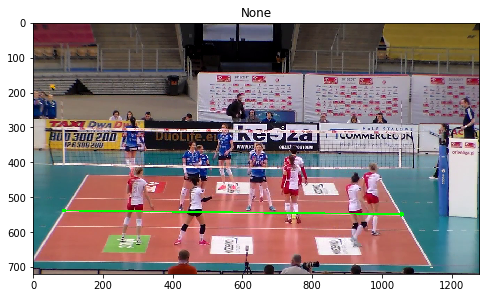

In [53]:
# PLot
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
cv2.circle(img, (center_left[0], center_left[1]), 1, color=(0,255,0), thickness=10)
cv2.circle(img, (center_right[0], center_right[1]), 1, color=(0,255,0), thickness=10)
cv2.line(img, pt1=center_left, pt2=center_right, color=(0, 255, 0), thickness=3)
plot_img(img, fs=(8,8), title=None)